# ML Privacy Meter (white-box) membership inference attack

## A note on installing ml_privacy_meter

`ml_privacy_meter` is not available through pip. You will need to clone the [git repository](https://github.com/privacytrustlab/ml_privacy_meter). The instructions suggest you install the requirements with `pip install -r requirements.txt`. This is not recommended. Instead, once the repository is cloned, install the module with `pip install -e .` from the `ml_privacy_meter` folder (ensuring you have any virtual environment you're using active when you do). When you attempt to import `ml_privacy_meter` you might find missing dependencies, which you can then install one by one (e.g. `openvino` and `torch`)

In [4]:
import os
from IPython.display import display, Image

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification, make_moons
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout

import ml_privacy_meter

### Create datasets

In [5]:
n_classes = 2
n_features = 300

# (X,y): Original distribution
X, y = make_classification(
    n_samples=1000,
    n_classes=n_classes,
    n_features=n_features,
    n_informative=n_features,
    n_redundant=0,
    n_repeated=0,
    random_state=15,
)
# One-hot encoding of the label
y = np.eye(n_classes)[y]

# (Xt, yt) is the target dataset, owned by the TRE and drawn from the (X,y) distribution
# (Xs, ys) is a shadow dataset drawn from the (X,y) distribution
Xt, Xs, yt, ys = train_test_split(X, y, test_size=0.50, random_state=15)

# (Xd, yd) is a shadow dataset, drawn from a different distribution (different seed)
Xd, yd = make_classification(
    n_samples=1000,
    n_classes=n_classes,
    n_features=n_features,
    n_informative=n_features,
    n_redundant=0,
    n_repeated=0,
    random_state=42,
)
yd = np.eye(n_classes)[yd]

### Train target model

In [6]:
# Split into train (member) and test (non-member) datasets
# Set shuffle to False so that Xt_membership is consistent with Xt, otherwise
# we need to stack Xt_member and Xt_nonmember again to get a consistent Xt.
Xt_member, Xt_nonmember, yt_member, yt_nonmember = train_test_split(
    Xt, yt, test_size=0.5, shuffle=False
)

# Set membership status for future tests
Xt_membership = np.vstack(
    (
        np.ones((Xt_member.shape[0], 1), np.uint8),
        np.zeros((Xt_nonmember.shape[0], 1), np.uint8),
    )
).flatten()

# Define target model
# Tensorflow model (MLP) (making it big to make it overfit)


def get_model():
    input_data = Input(shape=Xt_member[0].shape)
    x = Dense(128, activation="relu")(input_data)
    x = Dense(128, activation="relu")(x)
    x = Dense(64, activation="relu")(x)
    output = Dense(2, activation="softmax")(x)
    model = Model(input_data, output)
    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model


# Train target model
target_model = get_model()
r = target_model.fit(
    Xt_member,
    yt_member,
    validation_data=(Xt_nonmember, yt_nonmember),
    epochs=10,
    batch_size=32,
)

Epoch 1/10
8/8 [==============================] - 2s 78ms/step - loss: 1.9875 - accuracy: 0.5240 - val_loss: 1.8612 - val_accuracy: 0.5280
Epoch 2/10
8/8 [==============================] - 0s 15ms/step - loss: 0.1720 - accuracy: 0.9400 - val_loss: 1.5381 - val_accuracy: 0.5440
Epoch 3/10
8/8 [==============================] - 0s 19ms/step - loss: 0.0323 - accuracy: 0.9920 - val_loss: 1.4753 - val_accuracy: 0.5760
Epoch 4/10
8/8 [==============================] - 0s 21ms/step - loss: 0.0106 - accuracy: 1.0000 - val_loss: 1.5371 - val_accuracy: 0.5720
Epoch 5/10
8/8 [==============================] - 0s 17ms/step - loss: 0.0065 - accuracy: 1.0000 - val_loss: 1.4989 - val_accuracy: 0.5920
Epoch 6/10
8/8 [==============================] - 0s 17ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 1.4574 - val_accuracy: 0.5960
Epoch 7/10
8/8 [==============================] - 0s 20ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 1.4418 - val_accuracy: 0.6040
Epoch 8/10
8/8 [===========

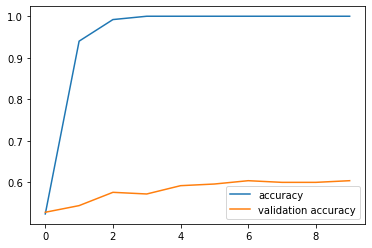

In [7]:
plt.plot(r.history["accuracy"], label="accuracy")
plt.plot(r.history["val_accuracy"], label="validation accuracy")
plt.legend()
plt.show()

### ML Privacy Meter attack

#### Convert data to the requisite format

In [8]:
def to_str(A, B):
    s = ""
    for i in range(len(A)):
        s += f"{A[i][0]}"
        for j in range(1, len(A[0])):
            s += f",{A[i][j]}"
        s += f";{np.argmax(B[i])}\n"
    return s


with open("Xt_nonmember.txt", "wt") as f:
    f.write(to_str(Xt_nonmember, yt_nonmember))

with open("Xt_member.txt", "wt") as f:
    f.write(to_str(Xt_member, yt_member))

with open("Xt_member.txt", "r") as f:
    dataset = f.readlines()
dataset = map(lambda i: i.strip("\n").split(";"), dataset)
dataset = np.array(list(dataset))
np.save("Xt_member.txt.npy", dataset)

#### Run white-box attack

In [9]:
saved_path = "Xt_member.txt.npy"  # memberset
dataset_path = "Xt_nonmember.txt"  # non-memberset

cmodelA = target_model

datahandlerA = ml_privacy_meter.utils.attack_data.attack_data(
    dataset_path=dataset_path,
    member_dataset_path=saved_path,
    batch_size=64,
    attack_percentage=50,
    input_shape=(n_features,),
)

attackobj = ml_privacy_meter.attack.meminf.initialize(
    target_train_model=cmodelA,
    target_attack_model=cmodelA,
    learning_rate=0.0001,
    optimizer="adam",
    train_datahandler=datahandlerA,
    attack_datahandler=datahandlerA,
    layers_to_exploit=[3, 4],
    gradients_to_exploit=[2, 3, 4],
)
attackobj.train_attack()


Target model test accuracy 0.624


c:\users\simonr04\git\ml_privacy_meter\ml_privacy_meter\utils\attack_utils.py:147: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  hashval = hash(bytes(np.array(example)))
c:\users\simonr04\git\ml_privacy_meter\ml_privacy_meter\utils\attack_utils.py:150: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  hashval = hash(bytes(np.array(example)))
c:\users\simonr04\git\ml_privacy_meter\ml_privacy_meter\attack\meminf.py:359: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with 

Epoch 0 over :Attack test accuracy: 0.5, Best accuracy : 0.5
Epoch 1 over :Attack test accuracy: 0.5, Best accuracy : 0.5
Epoch 2 over :Attack test accuracy: 0.5, Best accuracy : 0.5
Epoch 3 over :Attack test accuracy: 0.5759999752044678, Best accuracy : 0.5759999752044678
Epoch 4 over :Attack test accuracy: 0.5, Best accuracy : 0.5759999752044678
Epoch 5 over :Attack test accuracy: 0.5720000267028809, Best accuracy : 0.5759999752044678
Epoch 6 over :Attack test accuracy: 0.5, Best accuracy : 0.5759999752044678
Epoch 7 over :Attack test accuracy: 0.527999997138977, Best accuracy : 0.5759999752044678
Epoch 8 over :Attack test accuracy: 0.5239999890327454, Best accuracy : 0.5759999752044678
Epoch 9 over :Attack test accuracy: 0.5400000214576721, Best accuracy : 0.5759999752044678
Epoch 10 over :Attack test accuracy: 0.5479999780654907, Best accuracy : 0.5759999752044678
Epoch 11 over :Attack test accuracy: 0.5199999809265137, Best accuracy : 0.5759999752044678
Epoch 12 over :Attack test 

Epoch 91 over :Attack test accuracy: 0.8600000143051147, Best accuracy : 0.8880000114440918
Epoch 92 over :Attack test accuracy: 0.8600000143051147, Best accuracy : 0.8880000114440918
Epoch 93 over :Attack test accuracy: 0.8600000143051147, Best accuracy : 0.8880000114440918
Epoch 94 over :Attack test accuracy: 0.8519999980926514, Best accuracy : 0.8880000114440918
Epoch 95 over :Attack test accuracy: 0.8479999899864197, Best accuracy : 0.8880000114440918
Epoch 96 over :Attack test accuracy: 0.8479999899864197, Best accuracy : 0.8880000114440918
Epoch 97 over :Attack test accuracy: 0.8479999899864197, Best accuracy : 0.8880000114440918
Epoch 98 over :Attack test accuracy: 0.8479999899864197, Best accuracy : 0.8880000114440918
Epoch 99 over :Attack test accuracy: 0.8479999899864197, Best accuracy : 0.8880000114440918


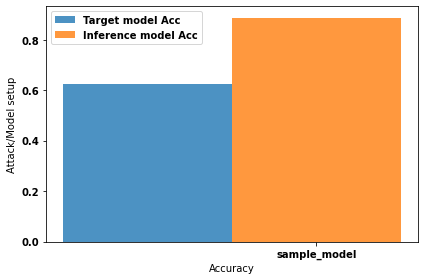

In [10]:
attackobj.test_attack()

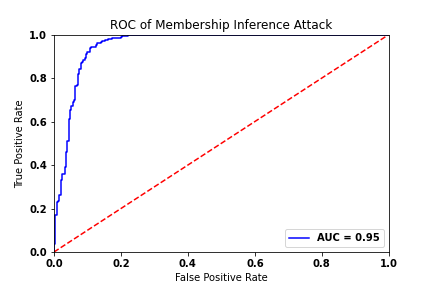

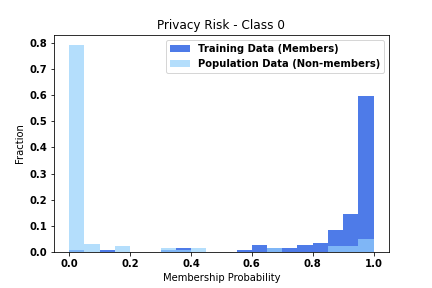

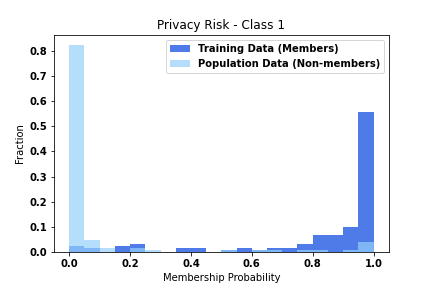

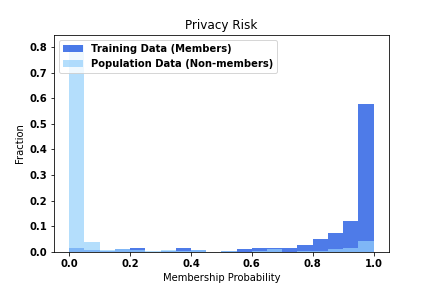

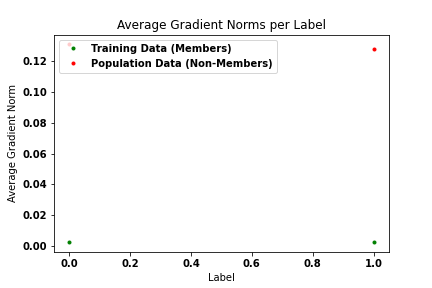

In [8]:
PLOT_PATH = os.path.normpath("logs/plots/")

for filename in os.listdir(PLOT_PATH):
    path = os.path.join(PLOT_PATH, filename)
    display(Image(path))